In [22]:
# Colab: install torchmetrics, download dataset

# !wget https://github.com/issyun/AutoOsu/raw/master/utils.py
# !pip install torchmetrics
# !gdown https://drive.google.com/uc?id=1xmDzRIv-RuPeqLDGY2zfOiiNAbyZp6jo
# !unzip -qq osu_dataset-06-16.zip

In [1]:
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence, pack_sequence, pad_packed_sequence
from torchmetrics.classification import BinaryF1Score
from torchmetrics.functional.text.perplexity import perplexity
from tqdm.auto import tqdm
from utils import find_file_by_stem

torch.set_printoptions(sci_mode=False)
RANDOM_SEED = 1
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\j827s\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
class OsuDataset:
    """
    Beatmap + audio dataset.
    GETITEM: specs, beat_phase, beat_num, difficulty, onsets, actions
    """

    def __init__(self, beatmap_path, audio_path):
        self.beatmap_fns = sorted(list(beatmap_path.glob('*.pt')))
        self.audio_fns = list(audio_path.glob('*.pt'))

    def __len__(self):
        return len(self.beatmap_fns)

    def __getitem__(self, idx):
        beatmap_fn = self.beatmap_fns[idx]
        audio_fn = find_file_by_stem(self.audio_fns, beatmap_fn.stem.split('-')[0])
        if audio_fn == -1:
            raise FileNotFoundError
        actions, onsets, _, difficulty = torch.load(beatmap_fn).values()
        specs, beat_phase, beat_num = torch.load(audio_fn).values()
        return specs, beat_phase, beat_num, difficulty, onsets, actions

In [4]:
class PadCollater:
    def __init__(self, device):
        self.device = device

    def __call__(self, batch):
        specs = []
        beat_phases = []
        beat_nums = []
        difficulties = []
        onsets = []
        actions = []
        lengths = []

        for x in batch:
            specs.append(x[0].to(self.device))
            lengths.append(x[0].shape[1])
            beat_phases.append(x[1].to(self.device))
            beat_nums.append(x[2].to(self.device))
            difficulties.append(x[3])
            onsets.append(x[4])
            actions.append(x[5])

        beat_phases = pad_sequence(beat_phases, batch_first=True)
        beat_nums = pad_sequence(beat_nums, batch_first=True)
        difficulties = torch.tensor(difficulties, device=self.device)
        actions = pad_sequence(actions, batch_first=True)
        lengths = torch.tensor(lengths)

        return specs, beat_phases, beat_nums, difficulties, onsets, actions, lengths

## Baseline Model

In [26]:
class OsuModel(nn.Module):
    def __init__(self, device, bp_emb_dim=16, bn_emb_dim=8, diff_emb_dim=8,
                 np_hidden_size=256, np_num_layers=2, ns_pre_proj_size=32,
                 ns_hidden_size=256, ns_num_layers=2, num_tokens=256):
        super().__init__()
        self.device = device
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.conv = nn.Conv2d(in_channels=3,
                              out_channels=1,
                              kernel_size=(15, 5),
                              padding='same')
        self.beat_phase_emb = nn.Embedding(49, bp_emb_dim)
        self.beat_num_emb = nn.Embedding(4, bn_emb_dim)
        self.difficulty_emb = nn.Embedding(21, diff_emb_dim)

        self.np_gru = nn.GRU(input_size=80 + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=np_hidden_size,
                             num_layers=np_num_layers,
                             batch_first=True,
                             bidirectional=True)
        self.np_proj_1 = nn.Linear(np_hidden_size*2, 128)
        self.np_proj_2 = nn.Linear(128, 1)

        self.ns_pre_proj = nn.Linear(128, ns_pre_proj_size)
        self.ns_gru = nn.GRU(input_size=80 + ns_pre_proj_size + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=ns_hidden_size,
                             num_layers=ns_num_layers,
                             batch_first=True,
                             bidirectional=False)
        self.ns_proj_1 = nn.Linear(ns_hidden_size, ns_hidden_size)
        self.ns_proj_2 = nn.Linear(ns_hidden_size, num_tokens)

    def forward(self, specs, beat_phases, beat_nums, difficulties, lengths):
        conv_outs = [self.gelu(self.conv(spec)).squeeze() for spec in specs]
        bp_emb = unpad_sequence(self.beat_phase_emb(beat_phases).to('cpu'),
                                lengths.to('cpu'), batch_first=True)
        bn_emb = unpad_sequence(self.beat_num_emb(beat_nums).to('cpu'),
                                lengths.to('cpu'), batch_first=True)
        diff = difficulties.unsqueeze(1).expand(-1, lengths.max().item())
        diff_emb = unpad_sequence(self.difficulty_emb(diff).to('cpu'),
                                  lengths.to('cpu'), batch_first=True)

        # ========== Note Placement ========== #

        np_in = []
        for i in range(len(lengths)):
            np_in.append(torch.cat([conv_outs[i],
                                    bp_emb[i].to(self.device),
                                    bn_emb[i].to(self.device),
                                    diff_emb[i].to(self.device)],
                                   dim=-1))
        np_in_packed = pack_sequence(np_in, enforce_sorted=False)
        np_out, last_hidden = self.np_gru(np_in_packed)
        np_out_padded, _ = pad_packed_sequence(np_out, batch_first=True)

        np_proj_1_out = self.gelu(self.np_proj_1(np_out_padded))
        np_pred = self.sigmoid(self.np_proj_2(np_proj_1_out)).squeeze()

        # ========== Note Selection ========== #

        ns_pre_proj_padded = self.ns_pre_proj(np_proj_1_out)
        ns_pre_proj = unpad_sequence(ns_pre_proj_padded, lengths, batch_first=True)
        ns_in = []
        for i in range(len(lengths)):
            ns_in.append(torch.cat([conv_outs[i],
                                    ns_pre_proj[i],
                                    bp_emb[i].to(self.device),
                                    bn_emb[i].to(self.device),
                                    diff_emb[i].to(self.device)],
                                   dim=-1))
        ns_in_packed = pack_sequence(ns_in, enforce_sorted=False)
        ns_out, last_hidden = self.ns_gru(ns_in_packed)
        ns_out_padded, _ = pad_packed_sequence(ns_out, batch_first=True)

        ns_proj_1_out = self.gelu(self.ns_proj_1(ns_out_padded))
        ns_logit = self.ns_proj_2(ns_proj_1_out)

        return np_pred, ns_logit

## ConvStack Model

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, hidden_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_size, 3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Conv2d(hidden_size, in_channels, 1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.block(x) + x

class ConvStack(nn.Module):
    def __init__(self, num_blocks, in_channels, hidden_size, out_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.first_conv = nn.Conv2d(in_channels, hidden_size, 1)
        self.first_norm = nn.BatchNorm2d(hidden_size)

        self.stack = nn.ModuleList([
            ConvBlock(hidden_size, hidden_size) for _ in range(num_blocks)
        ])

        self.last_conv = nn.Conv2d(hidden_size, out_channels, 1)
        self.last_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.first_norm(self.first_conv(x)))
        for block in self.stack:
            x = block(x)
        return self.relu(self.last_norm(self.last_conv(x)))

class StackModel(nn.Module):
    def __init__(self, device, num_stacks=7, bp_emb_dim=16, bn_emb_dim=8, diff_emb_dim=8,
                 np_hidden_size=256, np_num_layers=2, ns_pre_proj_size=32,
                 ns_hidden_size=256, ns_num_layers=2, num_tokens=256):
        super().__init__()
        self.device = device
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.stack = ConvStack(num_stacks, 3, 64, 1)
        self.beat_phase_emb = nn.Embedding(49, bp_emb_dim)
        self.beat_num_emb = nn.Embedding(4, bn_emb_dim)
        self.difficulty_emb = nn.Embedding(21, diff_emb_dim)

        self.np_gru = nn.GRU(input_size=80 + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=np_hidden_size,
                             num_layers=np_num_layers,
                             batch_first=True,
                             bidirectional=True)
        self.np_proj_1 = nn.Linear(np_hidden_size*2, 128)
        self.np_proj_2 = nn.Linear(128, 1)

        self.ns_pre_proj = nn.Linear(128, ns_pre_proj_size)
        self.ns_gru = nn.GRU(input_size=80 + ns_pre_proj_size + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=ns_hidden_size,
                             num_layers=ns_num_layers,
                             batch_first=True,
                             bidirectional=False)
        self.ns_proj_1 = nn.Linear(ns_hidden_size, ns_hidden_size)
        self.ns_proj_2 = nn.Linear(ns_hidden_size, num_tokens)

    def forward(self, specs, beat_phases, beat_nums, difficulties, lengths):
        conv_outs = [self.stack(spec).squeeze() for spec in specs]
        bp_emb = unpad_sequence(self.beat_phase_emb(beat_phases).to('cpu'),
                                lengths.to('cpu'), batch_first=True)
        bn_emb = unpad_sequence(self.beat_num_emb(beat_nums).to('cpu'),
                                lengths.to('cpu'), batch_first=True)
        diff = difficulties.unsqueeze(1).expand(-1, lengths.max().item())
        diff_emb = unpad_sequence(self.difficulty_emb(diff).to('cpu'),
                                  lengths.to('cpu'), batch_first=True)

        # ========== Note Placement ========== #

        np_in = []
        for i in range(len(lengths)):
            np_in.append(torch.cat([conv_outs[i],
                                    bp_emb[i].to(self.device),
                                    bn_emb[i].to(self.device),
                                    diff_emb[i].to(self.device)],
                                   dim=-1))
        np_in_packed = pack_sequence(np_in, enforce_sorted=False)
        np_out, last_hidden = self.np_gru(np_in_packed)
        np_out_padded, _ = pad_packed_sequence(np_out, batch_first=True)

        np_proj_1_out = self.gelu(self.np_proj_1(np_out_padded))
        np_pred = self.sigmoid(self.np_proj_2(np_proj_1_out)).squeeze()

        # ========== Note Selection ========== #

        ns_pre_proj_padded = self.ns_pre_proj(np_proj_1_out)
        ns_pre_proj = unpad_sequence(ns_pre_proj_padded, lengths, batch_first=True)
        ns_in = []
        for i in range(len(lengths)):
            ns_in.append(torch.cat([conv_outs[i],
                                    ns_pre_proj[i],
                                    bp_emb[i].to(self.device),
                                    bn_emb[i].to(self.device),
                                    diff_emb[i].to(self.device)],
                                   dim=-1))
        ns_in_packed = pack_sequence(ns_in, enforce_sorted=False)
        ns_out, last_hidden = self.ns_gru(ns_in_packed)
        ns_out_padded, _ = pad_packed_sequence(ns_out, batch_first=True)

        ns_proj_1_out = self.gelu(self.ns_proj_1(ns_out_padded))
        ns_logit = self.ns_proj_2(ns_proj_1_out)

        return np_pred, ns_logit

In [6]:
class Trainer():
    def __init__(self, model, optimizer, train_loader,
                 valid_loader, device, checkpoint_path:Path,
                 np_fl_gamma=2, np_fl_weight=0.8,
                 ns_fl_gamma=2, ns_fl_weight=0.8):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.checkpoint_path = checkpoint_path
        checkpoint_path.mkdir(exist_ok=True)
        self.np_fl_gamma=np_fl_gamma
        self.np_fl_weight=np_fl_weight
        self.ns_fl_gamma=ns_fl_gamma
        self.ns_fl_weight=ns_fl_weight

        self.start_epoch = 0
        self.train_np_loss_record = []
        self.train_ns_loss_record = []
        self.train_loss_record = []
        self.valid_np_loss_record = []
        self.valid_ns_loss_record = []
        self.valid_loss_record = []

        self.f1 = BinaryF1Score()
        self.train_np_f1_record = []
        self.valid_np_f1_record = []
        # self.train_ns_perp_record = []
        # self.valid_ns_perp_record = []

        # TODO: metrics (Perplexity, F-score, AUC...)

    def load_checkpoint(self, fn):
        checkpoint = torch.load(fn, map_location=self.device)
        self.start_epoch = checkpoint['epoch'] + 1
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if (torch.is_tensor(v)):
                    state[k] = v.to(self.device)
        self.train_np_loss_record = checkpoint['train_np_loss_record']
        self.train_ns_loss_record = checkpoint['train_ns_loss_record']
        self.train_loss_record = checkpoint['train_loss_record']
        self.valid_np_loss_record = checkpoint['valid_np_loss_record']
        self.valid_ns_loss_record = checkpoint['valid_ns_loss_record']
        self.valid_loss_record = checkpoint['valid_loss_record']
        self.train_np_f1_record = checkpoint['train_np_f1_record']
        self.valid_np_f1_record = checkpoint['valid_np_f1_record']
        # self.train_ns_perp_record = checkpoint['train_ns_perp_record']
        # self.valid_ns_perp_record = checkpoint['valid_ns_perp_record']

    def save_checkpoint(self, epoch, fn):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_np_loss_record': self.train_np_loss_record,
            'train_ns_loss_record': self.train_ns_loss_record,
            'train_loss_record': self.train_loss_record,
            'valid_np_loss_record': self.valid_np_loss_record,
            'valid_ns_loss_record': self.valid_ns_loss_record,
            'valid_loss_record': self.valid_loss_record,
            'train_np_f1_record': self.train_np_f1_record,
            'valid_np_f1_record': self.valid_np_f1_record,
            # 'train_ns_perp_record': self.train_ns_perp_record,
            # 'valid_ns_perp_record': self.valid_ns_perp_record
        }
        torch.save(checkpoint, fn)

    def binary_focal_loss(self, y, pred, gamma, pos_weight):
        """
        Biary focal loss for when y=1 is the minority class.\n
        INPUT
            gamma: factor for suppressing loss for easy examples (gamma > 1)
            pos_weight: how much to suppress loss when y=0 (0 <= pos_weight <= 1)
        """
        return -(y * (1-pred).pow(gamma) * pred.log() +
                 pos_weight * (1-y) * pred.pow(gamma) * (1-pred).log()).mean()

    def multi_focal_loss(self, y, pred, gamma, pos_weight):
        """
        Multi-class focal loss for when y=0 is the majority class.\n
        INPUT
            gamma: factor for suppressing loss for easy examples (gamma > 1)
            pos_weight: how much to suppress loss when y=0 (0 <= pos_weight <= 1)
        """
        p_y = pred[torch.arange(len(pred)), y]
        weight_mask = torch.where(y == 0, pos_weight, 1)
        return -(weight_mask * (1 - p_y).pow(gamma) * p_y.log()).mean()

    def train(self, num_epochs, reset_records=False):
        self.model.to(self.device)
        if reset_records:
            self.train_np_loss_record = []
            self.train_ns_loss_record = []
            self.train_loss_record = []
            self.valid_np_loss_record = []
            self.valid_ns_loss_record = []
            self.valid_loss_record = []
            self.train_np_f1_record = []
            self.valid_np_f1_record = []
            # self.train_ns_perp_record = []
            # self.valid_ns_perp_record = []

        for epoch in tqdm(range(self.start_epoch, num_epochs)):
            self.model.train()
            for batch in tqdm(self.train_loader, leave=False):
                specs, beat_phases, beat_nums, difficulties, onsets, actions, lengths = batch

                np_pred_padded, ns_logit = self.model(
                    specs, beat_phases, beat_nums, difficulties, lengths)

                np_pred = torch.cat(unpad_sequence(
                    np_pred_padded.to('cpu'), lengths.to('cpu'), batch_first=True), dim=-1)
                np_label = torch.cat(onsets, dim=-1).to('cpu')

                ns_pred = torch.cat(unpad_sequence(
                    ns_logit.to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=0).softmax(dim=-1)
                ns_label = torch.cat(unpad_sequence(
                    actions[:, 1:].to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=-1)

                np_loss = self.binary_focal_loss(
                    np_label, np_pred, self.np_fl_gamma, self.np_fl_weight)
                ns_loss = self.multi_focal_loss(
                    ns_label, ns_pred, self.ns_fl_gamma, self.ns_fl_weight)

                batch_loss = np_loss + ns_loss
                self.train_np_loss_record.append(np_loss.item())
                self.train_ns_loss_record.append(ns_loss.item())
                self.train_loss_record.append(batch_loss.item())

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                self.train_np_f1_record.append(self.f1(np_pred, np_label.int()).item())
                # self.train_ns_perp_record.append(perplexity(ns_pred.unsqueeze(0).detach(), ns_label.unsqueeze(0).long()).item())

            self.model.eval()
            with torch.inference_mode():
                for batch in tqdm(self.valid_loader, leave=False):
                    specs, beat_phases, beat_nums, difficulties, onsets, actions, lengths = batch

                    np_pred_padded, ns_logit = self.model(
                        specs, beat_phases, beat_nums, difficulties, lengths)

                    np_pred = torch.cat(unpad_sequence(
                        np_pred_padded.to('cpu'), lengths.to('cpu'), batch_first=True), dim=-1)
                    np_label = torch.cat(onsets, dim=-1).to('cpu')

                    ns_pred = torch.cat(unpad_sequence(
                        ns_logit.to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=0).softmax(dim=-1)
                    ns_label = torch.cat(unpad_sequence(
                        actions[:, 1:].to('cpu'), lengths.to('cpu')-1, batch_first=True), dim=-1)

                    np_loss = self.binary_focal_loss(
                        np_label, np_pred, self.np_fl_gamma, self.np_fl_weight)
                    ns_loss = self.multi_focal_loss(
                        ns_label, ns_pred, self.ns_fl_gamma, self.ns_fl_weight)

                    batch_loss = np_loss + ns_loss
                    self.valid_np_loss_record.append(np_loss.item())
                    self.valid_ns_loss_record.append(ns_loss.item())
                    self.valid_loss_record.append(batch_loss.item())

                    self.valid_np_f1_record.append(self.f1(np_pred, np_label.int()).item())
                    # self.valid_ns_perp_record.append(perplexity(ns_pred.unsqueeze(0).detach(), ns_label.unsqueeze(0).long()).item())

            time = datetime.now().strftime('%m-%d-%H-%M-%S')
            checkpoint_path = Path(self.checkpoint_path / f'{time}-epoch{epoch}.pt')
            self.save_checkpoint(epoch, checkpoint_path)

## Train Baseline Model

In [28]:
beatmap_path = Path('/content/beatmap/4keys')
audio_path = Path('/content/audio')

base_set = OsuDataset(beatmap_path, audio_path)
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_set, valid_set = torch.utils.data.random_split(
    base_set, [0.8, 0.2], generator)

collater = PadCollater(device=DEV)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=12, shuffle=True, generator=generator, collate_fn=collater, drop_last=True)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=4, shuffle=False, collate_fn=collater, drop_last=True)

model = OsuModel(device=DEV)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, train_loader, valid_loader,
                  device=DEV, checkpoint_path=Path('checkpoints'),
                  ns_fl_gamma=2, ns_fl_weight=0.8,
                  np_fl_gamma=3, np_fl_weight=0.3)

## Train ConvStack Model

In [11]:
beatmap_path = Path('osu_dataset/beatmap/4keys/')
audio_path = Path('osu_dataset/audio/')

base_set = OsuDataset(beatmap_path, audio_path)
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_set, valid_set = torch.utils.data.random_split(
    base_set, [0.8, 0.2], generator)

collater = PadCollater(device=DEV)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=12, shuffle=True, generator=generator, collate_fn=collater, drop_last=True)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=4, shuffle=False, collate_fn=collater, drop_last=True)

model = StackModel(device=DEV)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, train_loader, valid_loader,
                  device=DEV, checkpoint_path=Path('checkpoints/convstack/'),
                  ns_fl_gamma=2, ns_fl_weight=0.8,
                  np_fl_gamma=3, np_fl_weight=0.3)

In [12]:
trainer.train(20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

ValueError: expected 4D input (got 3D input)

### Training Test

In [ ]:
trainer.start_epoch = 14
trainer.train(16)

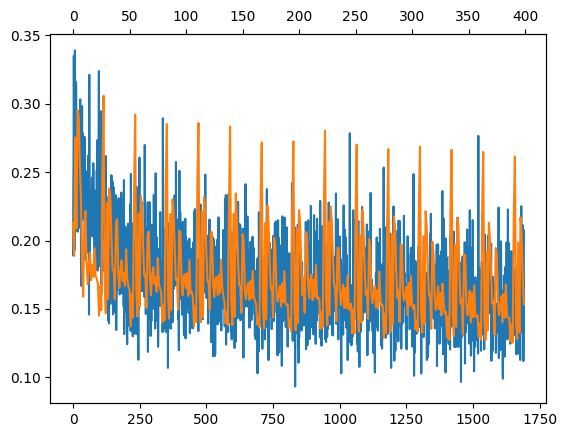

In [47]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(trainer.train_loss_record[20:], color='tab:blue')
ax2 = ax1.twiny()
ax2.plot(trainer.valid_loss_record[20:], color='tab:orange')

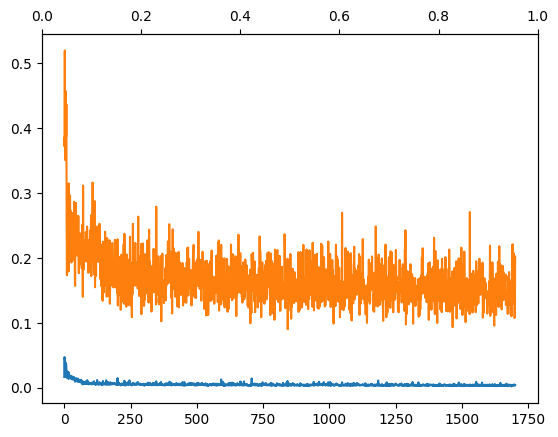

In [48]:
fig, ax1 = plt.subplots()
ax1.plot(trainer.train_np_loss_record[10:], color='tab:blue')
ax2 = ax1.twiny()
ax1.plot(trainer.train_ns_loss_record[10:], color='tab:orange')

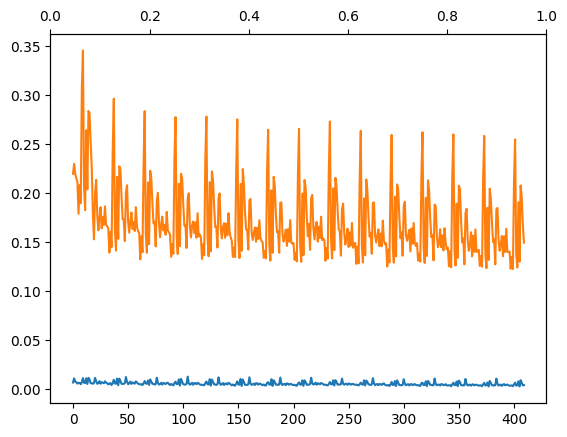

In [49]:
fig, ax1 = plt.subplots()
ax1.plot(trainer.valid_np_loss_record[10:], color='tab:blue')
ax2 = ax1.twiny()
ax1.plot(trainer.valid_ns_loss_record[10:], color='tab:orange')

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


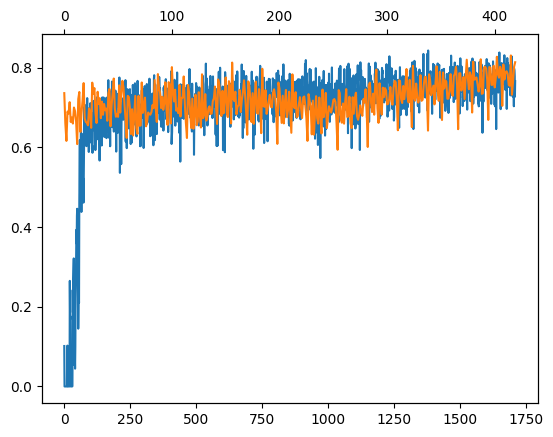

In [52]:
fig, ax1 = plt.subplots()
ax1.plot(trainer.train_np_f1_record, color='tab:blue')
ax2 = ax1.twiny()
ax2.plot(trainer.valid_np_f1_record, color='tab:orange')